# Steane Code Restricting Connectivity

If there is a file import error make sure you are in the correct path

In [ ]:
import sys
sys.path.append('..')   # the `general_qec` package sits above us

In [ ]:
import numpy as np
import random
from general_qec.qec_helpers import *
from general_qec.gates import *
from general_qec.errors import *
from circuit_specific.steane_helpers import *

## Contents
1. [Introduction](#introduction)
2. [Line Connectivity](#line)
    1. [Circuit Representation](#linecircuit)
    2. [Line Connectivity Implementation](#linecode)
3. [Grid Connectivity](#grid)
    1. [Circuit Representation](#gridcircuit)
    2. [Grid Connectivity Implementation](#gridcode)

## 1. Introduction <a id='introduction'></a>

In this file we will restrict the connectivity of the 7-qubit Steane Code with 3 ancilla qubits to line connectivity and grid connectivity in order to demonstrate the gate operations needed to implement this circuit in a more realistic setting. Remember our Steane error correcting code looks like this:

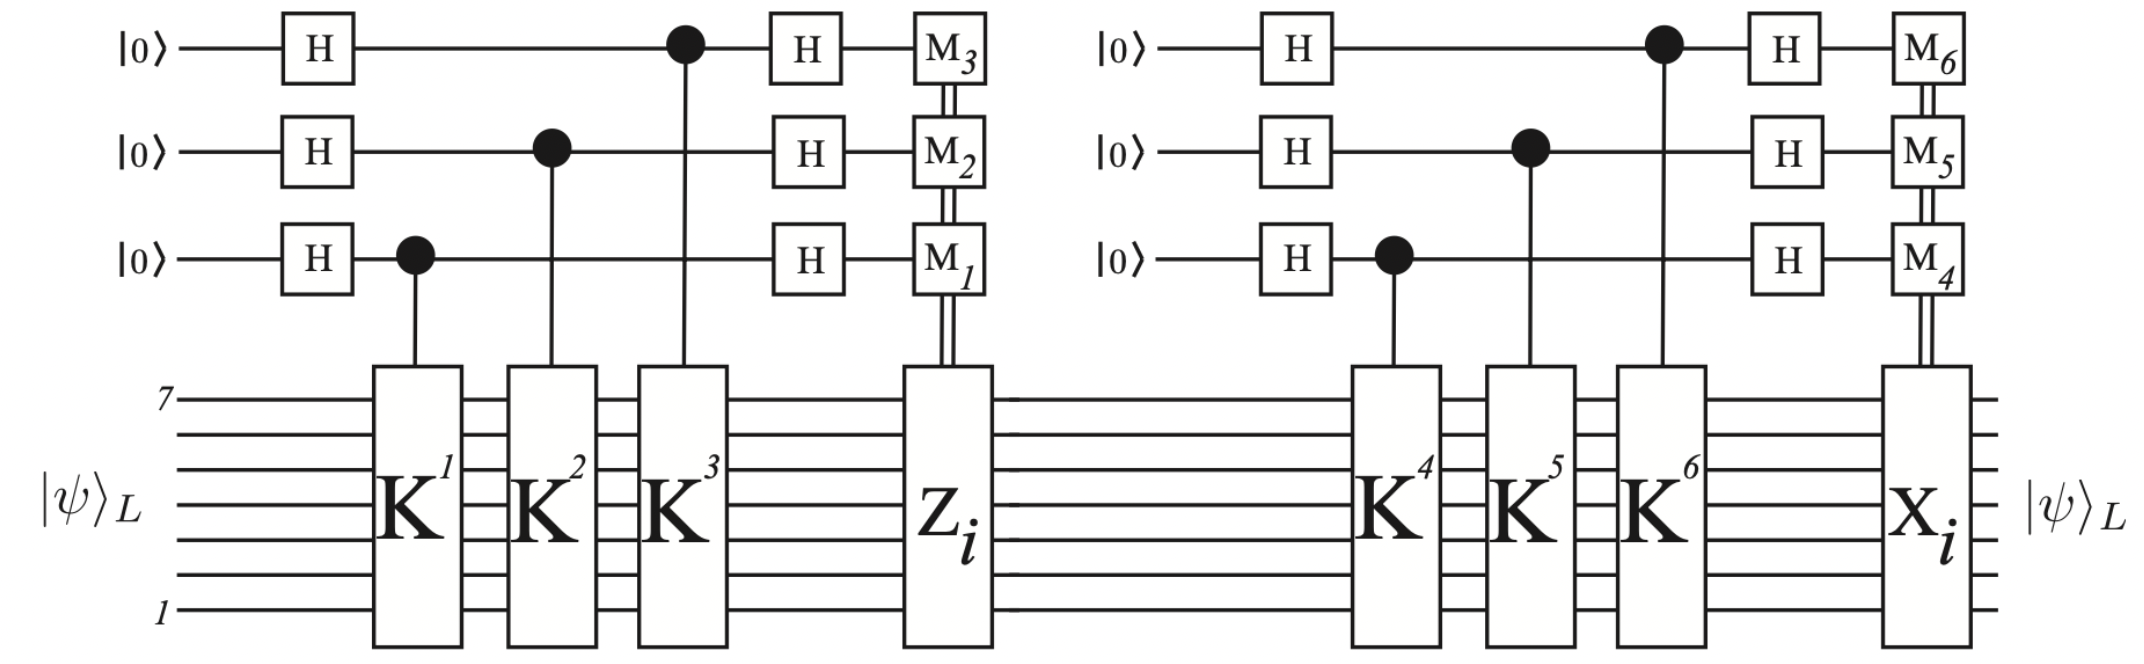

## 2. Line Connectivity <a id='line'></a>

During our previous implementation of the Steane code we used the assumption of all-to-all connectivity, which means that all qubits are coupled to each other. This allows us to implement any two qubit gate from any one qubit to another using only one single gate. However, this is not the case in physical systems. In reality physical systems will be able to couple only a few qubits to each other. This will impact the probability of error due to the fact that we will now need to implement a much larger number of gates than before (due to SWAP operations), and these gates always have some sort of probability for error.

Thus we will first implement the case where we have line connectivity. So we will need to break up each of our Stabilizer Gates into their individual components and then take the adjacent qubit CNOT representations of each.

Remember our stabilizers look like this:

$$K^1 = IIIXXXX, \quad K^2 = XIXIXIX, \quad K^3 = IXXIIXX, $$
$$K^4 = IIIZZZZ, \quad K^5 = ZIZIZIZ, \quad K^6 = IZZIIZZ $$

We may split each of these into the following:

$$ K^1 = IIIXXXX = (IIIXIII)(IIIIXII)(IIIIIXI)(IIIIIIX), $$
$$ K^2 = XIXIXIX = (XIIIIII)(IIXIIII)(IIIIXII)(IIIIIIX), $$
$$ K^3 = IXXIIXX = (IXIIIII)(IIXIIII)(IIIIIXI)(IIIIIIX), $$
$$ K^4 = IIIZZZZ = (IIIZIII)(IIIIZII)(IIIIIZI)(IIIIIIZ), $$
$$ K^5 = ZIZIZIZ = (ZIIIIII)(IIZIIII)(IIIIZII)(IIIIIIZ), $$
$$ K^6 = IZZIIZZ = (IZIIIII)(IIZIIII)(IIIIIZI)(IIIIIIZ), $$

where operators inside the parentheses are combined through kronecker products, while between the parentheses we use a dot product. 

When we use each ancilla as a control, we are just applying a CNOT gate for each term in the operators $K_1, K_2, K_3$ and a Control-Z gate for each term in the operators $K_4, K_5, K_6$.

### A. Circuit Representation <a id='linecircuit'></a>

In our case the circuit representation would look like this (below). And now we can split each of the CNOT and Control-Z gates into their adjacent qubit gate operations.

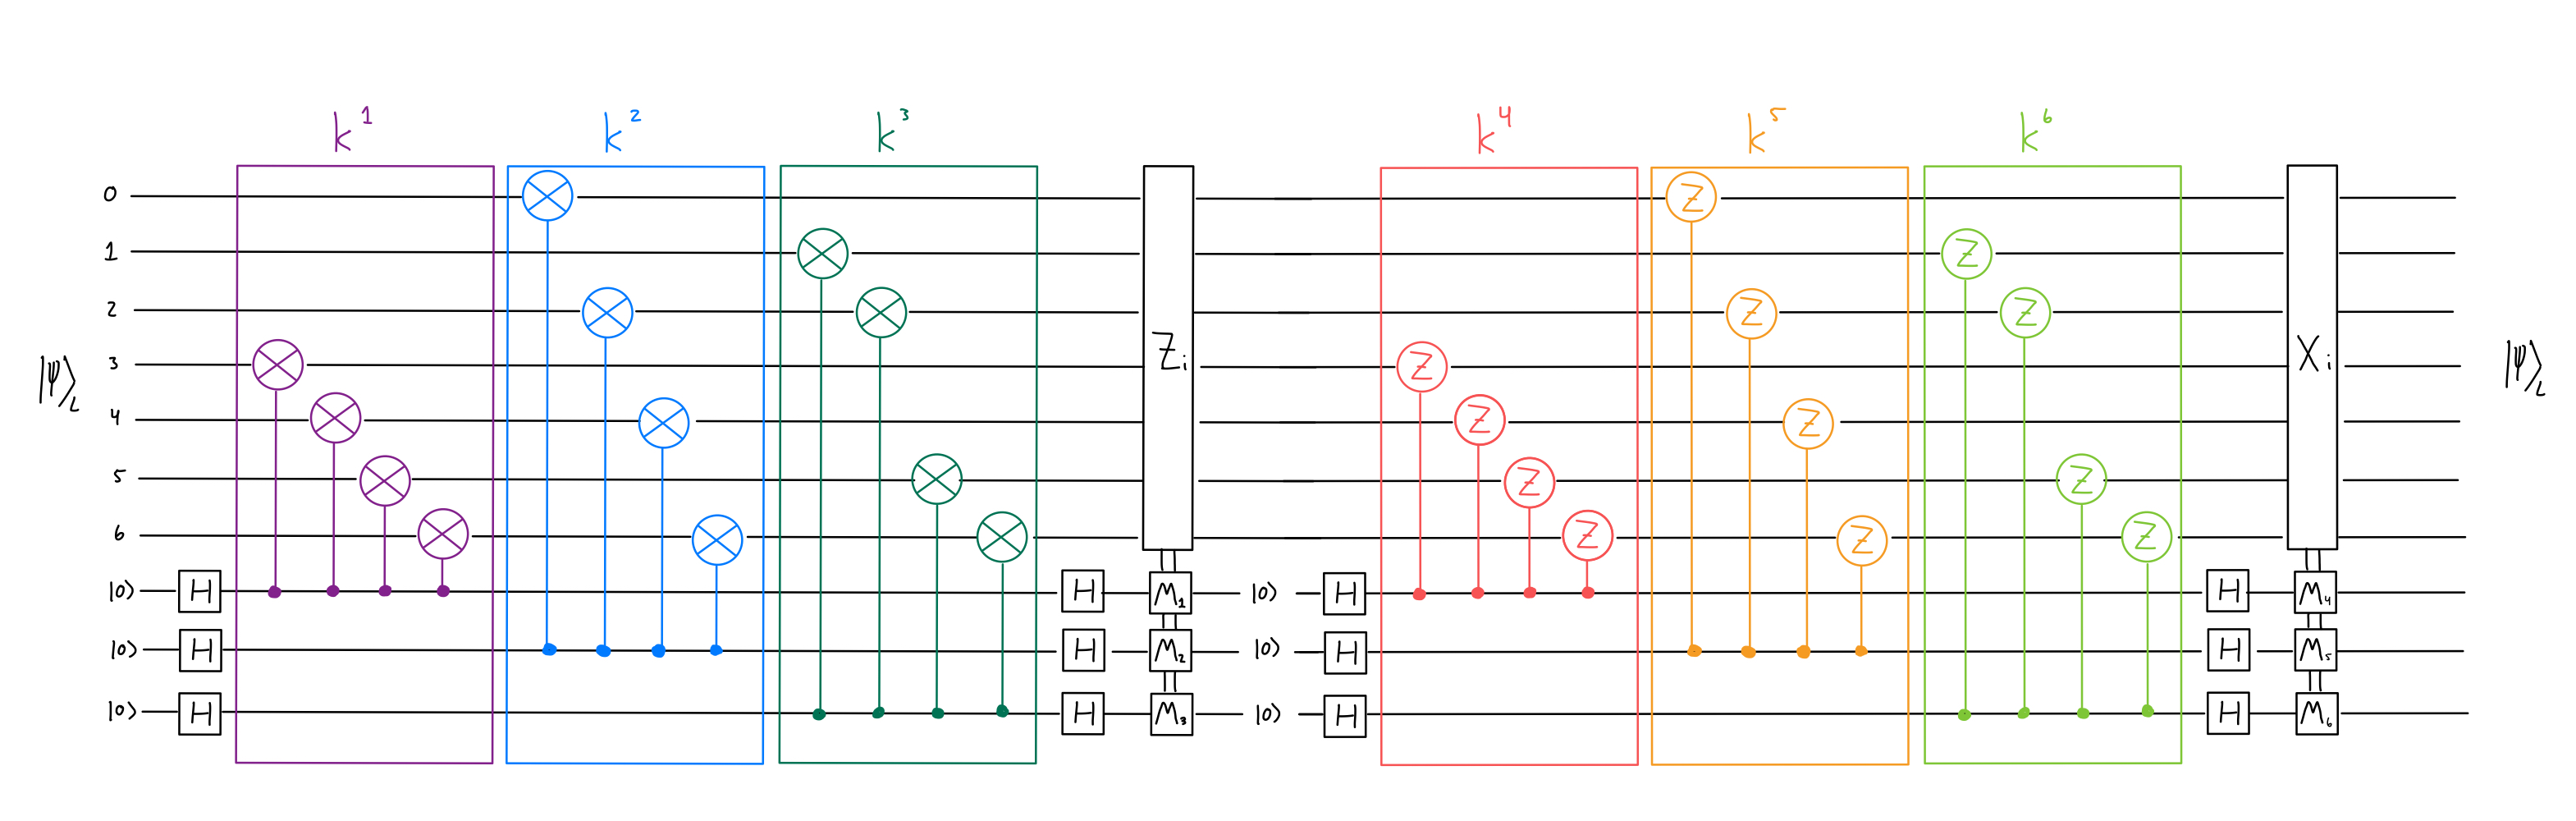

### B. Line Connectivity Implementation <a id='linecode'></a>

Set the initial states of your physical qubits

In [ ]:
# initial_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

initial_state = np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))))

# initial_state = 1/np.sqrt(2) * np.kron(np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(
#     np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(
#         np.array([[1,1]]), np.array([[1,1]])))))))


#### Initialize a logical state using CNOT operations and line connectivity
In this case we can use our non-adj CNOT calculations since they implement line connectivity as shown in <u>02b. 3 qubit Restricting Connectivity</u>, but this time a new function is made since the indices of the control and target qubit in the CNOT are actually flipped in this case.


In [ ]:
# Run the initialization function for the steane 7 qubit code
initialized_logical_state = initialize_steane_line_conn(initial_state)

# collapse the ancilla state and normalize it correctly
logical_vector_state = collapse_ancilla(initialized_logical_state, 3)

# superposition state normalization
# logical_vector_state = collapse_ancilla(1/(2*np.sqrt(2)) * initialized_logical_state, 3)

# Display the current state (with ancillas)
print('Initialized logical state: (by amplitude) ')
print_state_info(logical_vector_state, 10)

In [ ]:
# Reset our ancilla qubits after initializing
logical_vector_state = ancilla_reset(logical_vector_state, 3)
# Display the current state (with ancillas)
print('Initialized logical state: (by amplitude) ')
print_state_info(logical_vector_state, 10)

Now we apply a random error and show the code can correct for it.

In [ ]:
# Apply our two errors
error_state = random_qubit_z_error(random_qubit_x_error(logical_vector_state, [0, 6])[0], [0, 6])[0]
# error_state = phase_flip_error(logical_vector_state, 10)[0]

# Display the current state (remove ancillas)
print('Errored logical state: ')
print_state_info(error_state, 7)

Remember that the correction circuit looks the same as the initialization in this case. So we can just run the phase error and bit correction functions which look similar to our initialization function.

In [ ]:
# First apply our phase correction
phase_corrected_state = steane_line_conn_phase_correction(error_state)

# Display the current state (remove ancillas)
print('Phase corrected logical state: ')
print_state_info(phase_corrected_state, 7)

In [ ]:
# Reset the ancillas
phase_corrected_state = ancilla_reset(phase_corrected_state, 3)

# Display the current state (with ancillas)
print('Phase corrected logical state: (with ancillas reset)')
print_state_info(phase_corrected_state, 10)

In [ ]:
# Next apply our bit correction
bit_corrected_state = steane_line_conn_bit_correction(phase_corrected_state)

# Display the current state (remove ancillas)
print('Bit corrected logical state: ')
print_state_info(bit_corrected_state, 7)

## 3. Grid Connectivity <a id='grid'></a>

Now that we have demonstrated restriction to line connectivity for the 7 qubit Steane code with one acilla block, we will move to restricting our system to grid connectivity. In most cases this type of connectivity allows for more flixibility depending on how you lay out your qubit system.

The drawing below represents a diagram of what the operations would look like for a grid connected 3 x 4 qubit system (using 10 of the 12 qubits). We chose the positions of the qubits to somewhat optimize the number of gates needed (less is better) since single and two qubit gates cause errors to occur in realisitic computations. Additionally we assumed that all the qubits are identical.

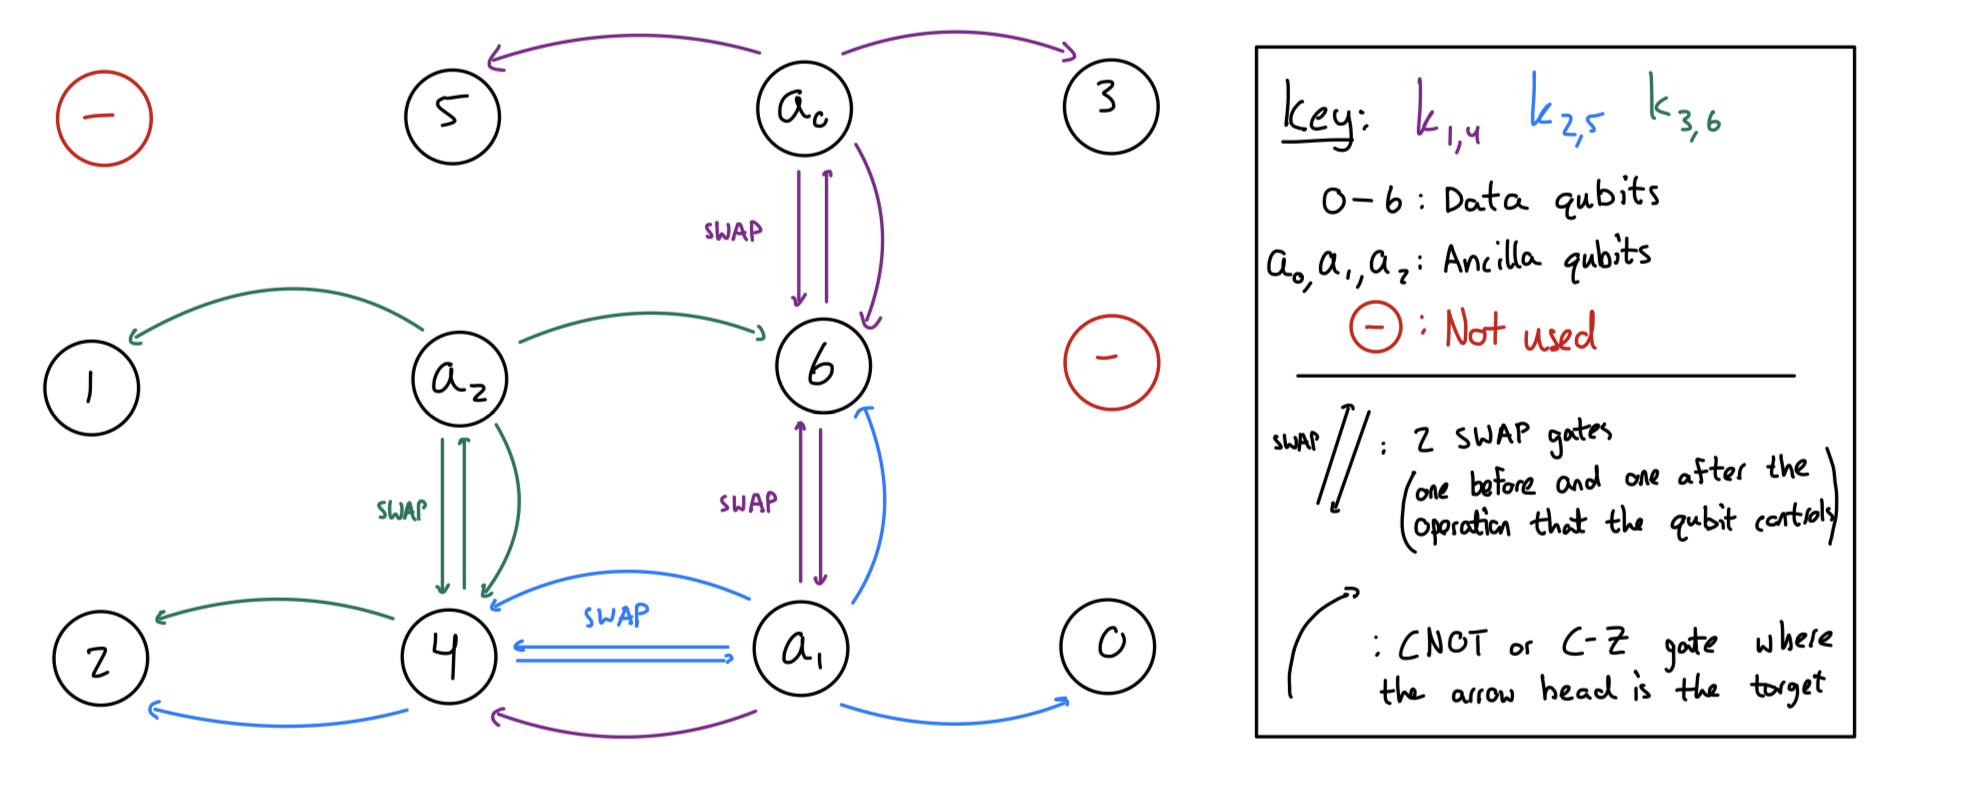

### A. Circuit Representation <a id='gridcircuit'></a>

Below we show the circuit representation of the following grid connected qubit system. Remeber that even though the circuit representation does not show the CNOT and Control-Z gates as adjacent, in reality they all are. Additionally, remember that the SWAP gate can be composed of 3 CNOT gates.

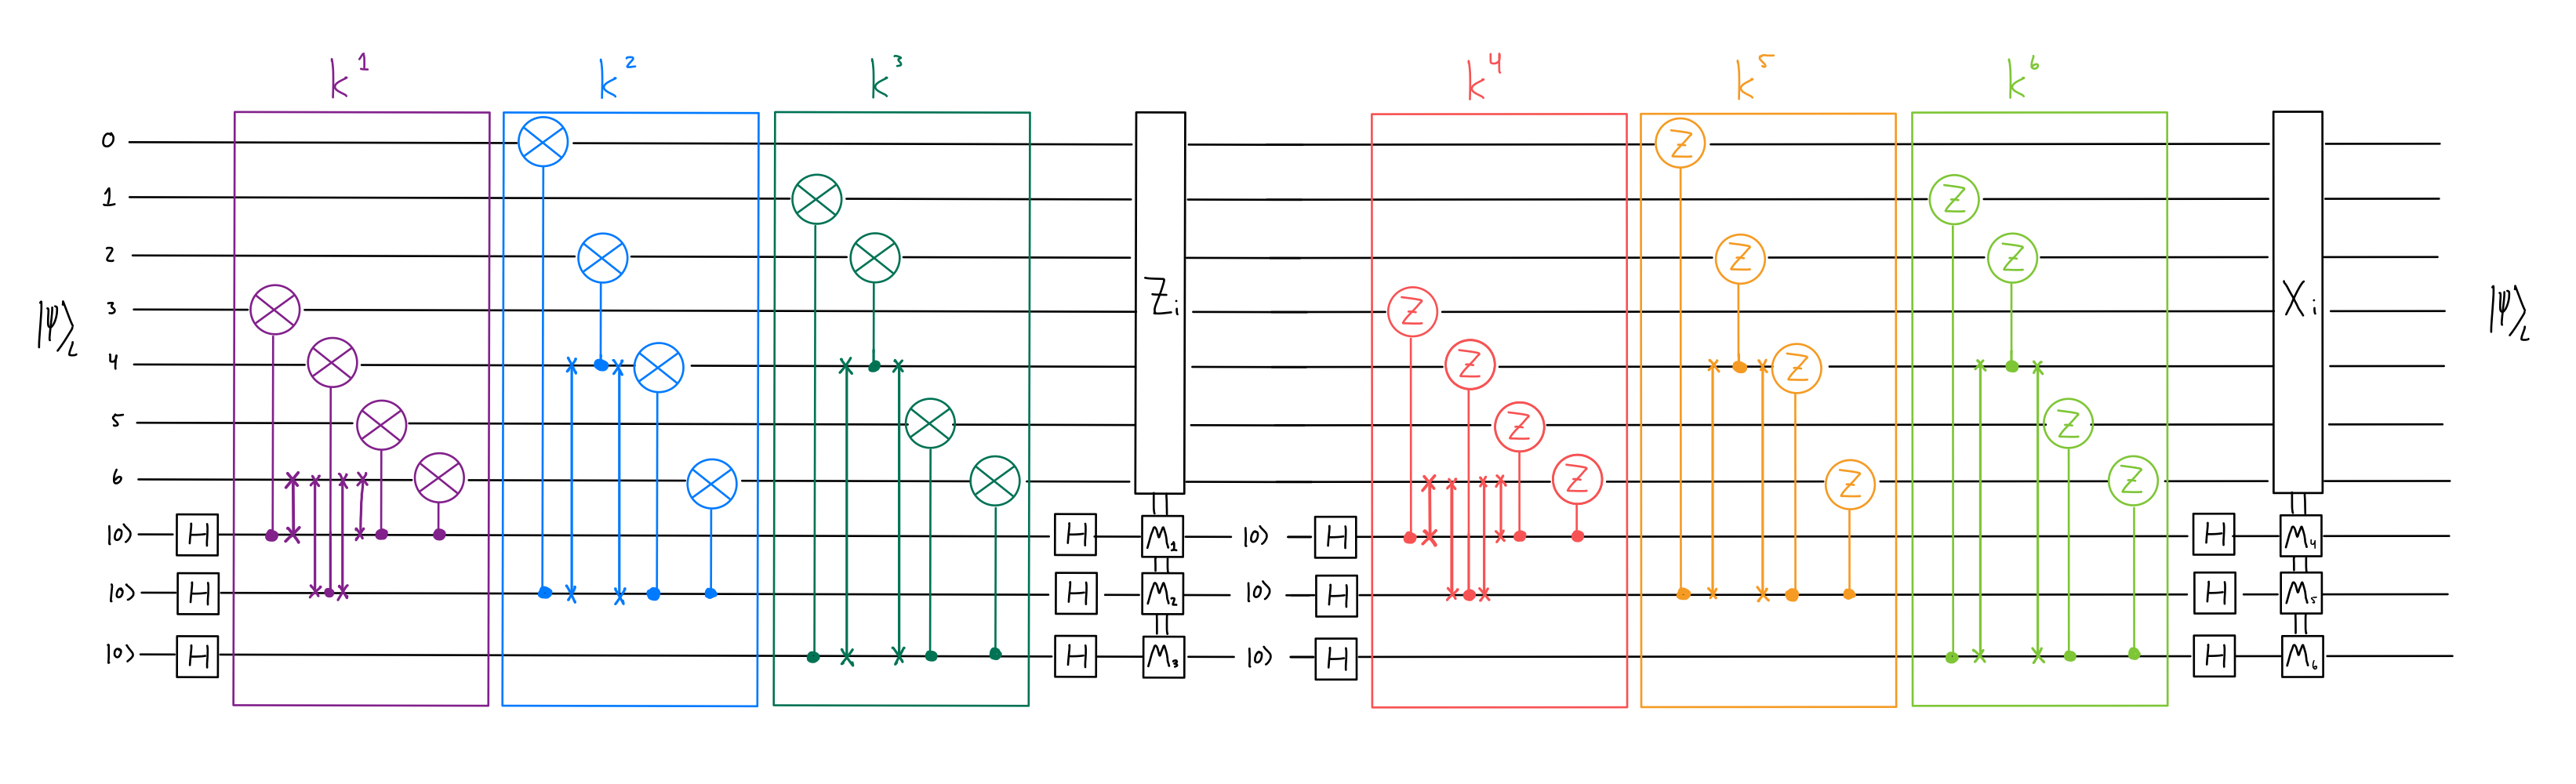

### B. Grid Connectivity Implementation <a id='gridcode'></a>

Set the initial states of your physical qubits

In [ ]:
# initial_state = np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, np.kron(zero, zero))))))

initial_state = np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, np.kron(one, one))))))

# initial_state = 1/np.sqrt(2) * np.kron(np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(
#     np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(np.array([[1,1]]), np.kron(
#         np.array([[1,1]]), np.array([[1,1]])))))))

#### Initialize a logical state using CNOT operations and grid connectivity

In this case we can use our non-adj CNOT calculations since they will give us the matrix representation of any CNOT gate in the system. Since we are using grid connectivity we implement SWAP gates when calculating the matrix representation of the Stabilizer operators.

In [ ]:
# Run the initialization function for the steane 7 qubit code
initialized_logical_state = initialize_steane_grid_conn(initial_state)

# collapse the ancilla state and normalize it correctly
logical_vector_state = collapse_ancilla(initialized_logical_state, 3)

# superposition state normalization
# logical_vector_state = collapse_ancilla(1/(2*np.sqrt(2)) * initialized_logical_state, 3)

# Display the current state (with ancillas)
print('Initialized logical state: (by amplitude) ')
print_state_info(logical_vector_state, 10)

In [ ]:
# Reset our ancilla qubits after initializing
logical_vector_state = ancilla_reset(logical_vector_state, 3)
# Display the current state (with ancillas)
print('Initialized logical state: (by amplitude) ')
print_state_info(logical_vector_state, 10)

Now we apply a random error and show the code can correct for it.

In [ ]:
# Apply our two errors
error_state = random_qubit_z_error(random_qubit_x_error(logical_vector_state, [0, 6])[0], [0, 6])[0]
# error_state = phase_flip_error(logical_vector_state, 10)[0]

# Display the current state (remove ancillas)
print('Errored logical state: ')
print_state_info(error_state, 7)

Remember that the correction circuit looks the same as the initialization in this case. So we can just run the phase error and bit correction functions which look similar to our initialization function.

In [ ]:
# First apply our phase correction
phase_corrected_state = steane_grid_conn_phase_correction(error_state)

# Display the current state (remove ancillas)
print('Phase corrected logical state: ')
print_state_info(phase_corrected_state, 7)

In [ ]:
# Reset the ancillas
phase_corrected_state = ancilla_reset(phase_corrected_state, 3)

# Display the current state (with ancillas)
print('Phase corrected logical state: (with ancillas reset)')
print_state_info(phase_corrected_state, 10)

In [ ]:
# Next apply our bit correction
bit_corrected_state = steane_grid_conn_bit_correction(phase_corrected_state)

# Display the current state (remove ancillas)
print('Bit corrected logical state: ')
print_state_info(bit_corrected_state, 7)